# Assignment 3

### Task 1 - Simulation

### Task 2 - Predicting Power with SAR(2)

### Task 3 - Box heating with ARX

The final part is about identifying a suitable ARX model for predicting the hourly heating of a test box (a small building). The box has a window in the south facing wall.

In an experiment times series were recorded of the variables:
- $P_h$ (Ph in data) the heat from electrical heaters (W).
- $T_{\text{delta}}$ (Tdelta in data) the difference between the internal and external temperature (◦C)
- $G_v$ (Gv in data) the vertical solar radiation onto the box side with a window (W/m2)

The data consists of average hourly values – in total 231 hours. It’s available in the ```box_data_60min.csv``` file.

In the experiment the internal air temperature was kept constant with a thermostatic control of the heating – hence the heating change depending on the weather conditions.

The objective is to find a suitable model, which makes good predictions of the heating.

Lags have been generated and included in the data with a naming syntax such that, e.g.: Ph.l1 is the heating lagged one step, Ph.l2 is heating lagged two steps and so fourth.

##### 3.1

In [2]:
import pandas as pd

df = pd.read_csv("./../data/box_data_60min.csv")
df.tdate = pd.to_datetime(df.tdate)
df.set_index(df.tdate, inplace=True)
# thour starts at 19!?! --> re-index
df['thour'] = range(1,len(df)+1)

/var/folders/5b/3rjqcwwn5s93khgglxljhv140000gn/T/ipykernel_71054/3940847846.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(df.tdate.apply(lambda x: x.hour))


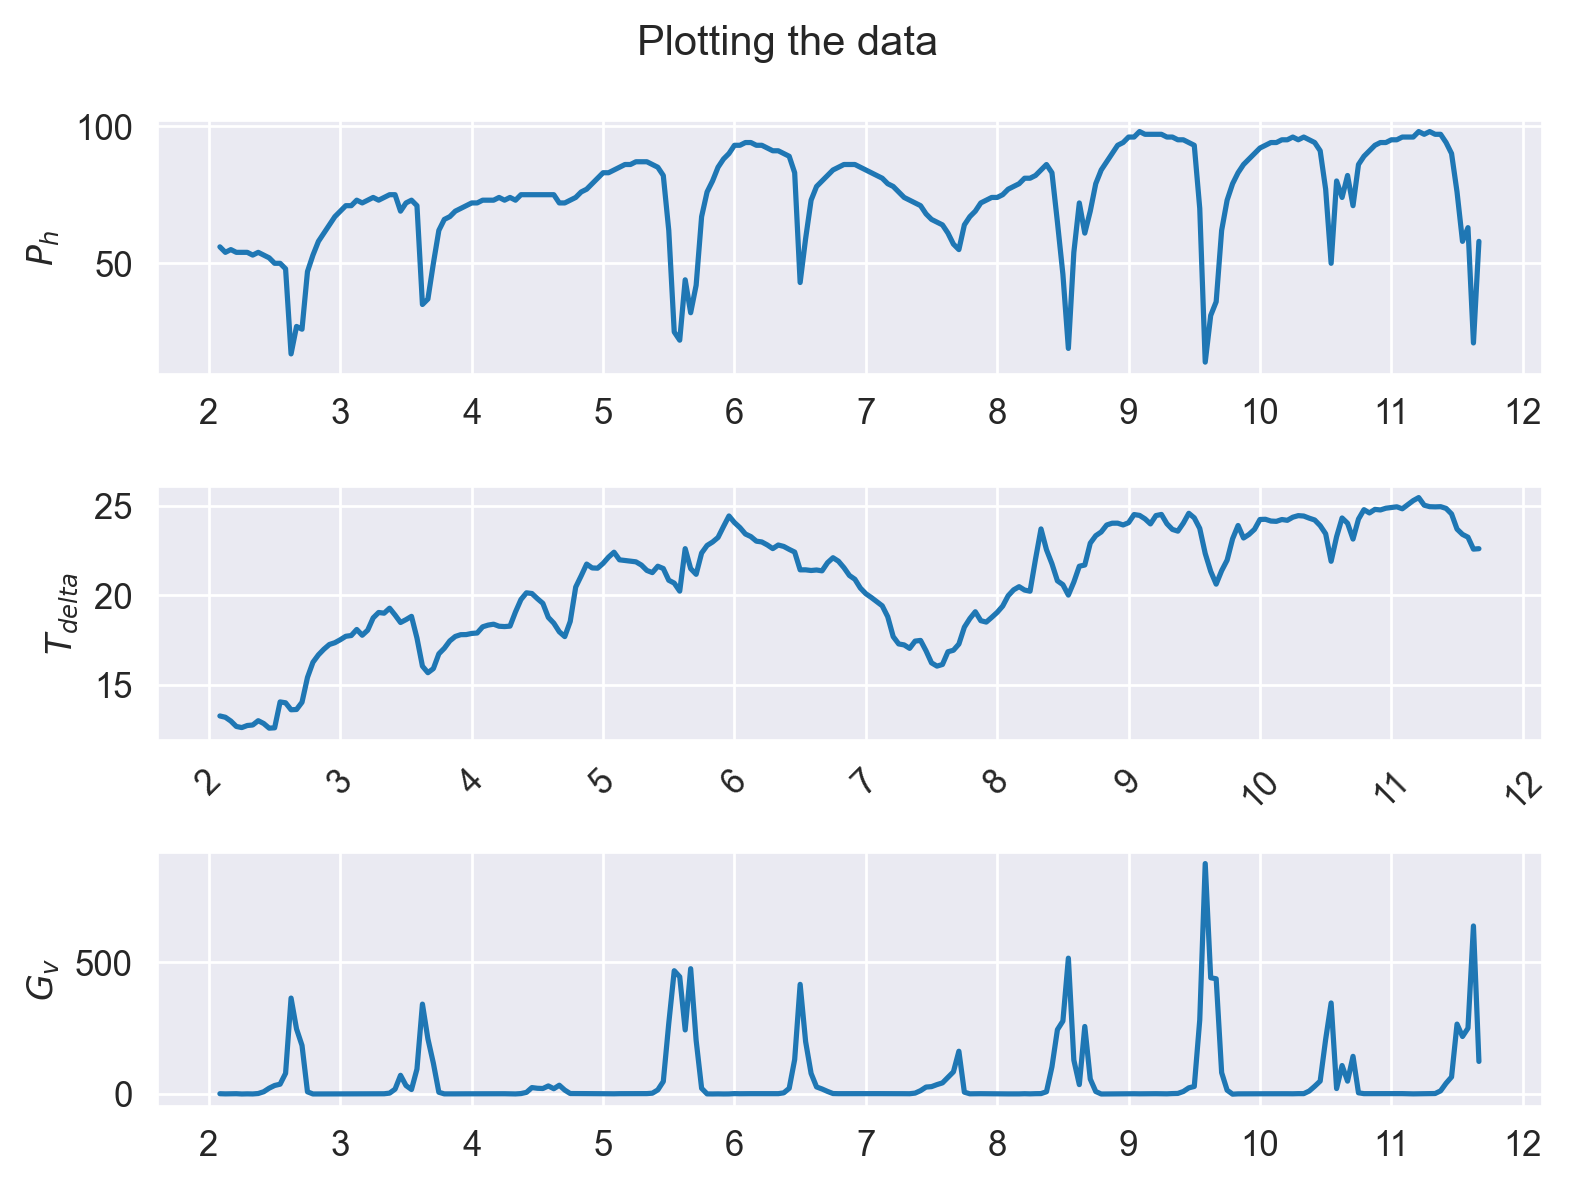

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

fig = plt.figure(dpi=250)
fig.suptitle("Plotting the data")
ax3 = plt.subplot(313)
ax1 = plt.subplot(311, sharex=ax3)
ax2 = plt.subplot(312, sharex=ax3)

ax1.plot(df.Ph)
ax1.set_xticklabels([])
ax1.set_ylabel("$P_h$")

ax2.plot(df.Tdelta)
ax2.set_ylabel("$T_{delta}$")

ax3.plot(df.Gv)
ax3.set_ylabel("$G_v$")
ax3.set_xticklabels(df.tdate.apply(lambda x: x.hour))

plt.xticks(rotation=45)
plt.tight_layout()

*Comment:*

Clearly there is an inverse relation between $P_h$ and $G_v$, which is just by construction. The peaks of $G_v$ and the drops in $G_v$ conincide, however, not in value magnitude but just in location and relative severity. 

Additionally, the drops are also present in $T_d$, whilst significantly weaker than in $P_h$.

Tracing along all the buckling peaks of $P_h$ and the peaks of $T_d$, one can observe a notion of a correlated moving trendline.

##### 3.2

In [4]:
cutoff = "2013-02-06 00:00"
df_train = df[df.tdate<=cutoff]

##### 3.3 investigate relationships

In [5]:
import numpy as np

# cross correlation - non-commutative but symmetric; time-lagged correlation; convolution
pg = np.correlate(df_train.Ph, df_train.Gv)
pt = np.correlate(df_train.Ph, df_train.Tdelta, mode='full')
gt = np.correlate(df_train.Gv, df_train.Tdelta, mode='same')

# correlation
corr = df_train[['Ph', 'Gv', 'Tdelta']].corr()

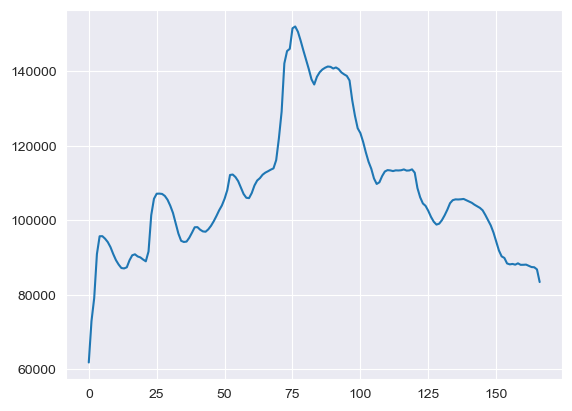

In [6]:
plt.plot(gt)

<Axes: >

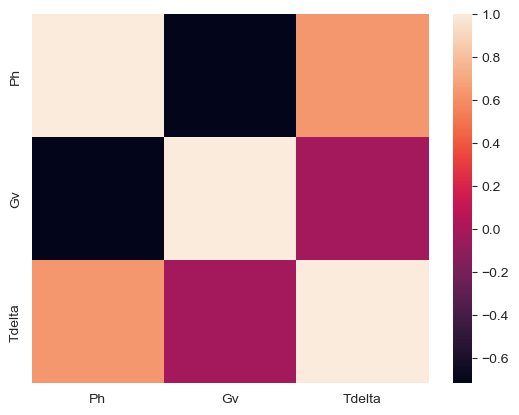

In [7]:
sns.heatmap(corr)

In [ ]:
# scatter plots
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
plt.scatter(scaler.fit_transform(df_train.Ph.to_numpy().reshape(-1,1)), scaler.fit_transform(df_train.Gv.to_numpy().reshape(-1,1)))
plt.scatter(scaler.fit_transform(df_train.Tdelta.to_numpy().reshape(-1,1)), scaler.fit_transform(df_train.Gv.to_numpy().reshape(-1,1)))
plt.scatter(scaler.fit_transform(df_train.Tdelta.to_numpy().reshape(-1,1)), scaler.fit_transform(df_train.Ph.to_numpy().reshape(-1,1)))

##### 3.4

**Question:** Which series should be the impulse and which should model the response?
- T with G as impulse?
- T with G and P as impulse?
- P with T and G as impulse? <-- probably this

Estimating the impulse response, usually involves knowing the parameters for a model. The goal is to see how a unit-impulse in the beginning propagates recursively throughout the model. 

*model/ recursion for impulse response from slides*

For a model with lag $k$ up to $10$, we need at least $10$ coefficients (for each time-series) for the model, since the signal shall be dependent on $10$ past observations, this makes $20$ total parameters for a model with ONE exogenous variable or $30$ with 2 exogenous variables. Assume a model, where $\{T_t\}$ represents the series $T_{\text{delta}}$, $\{G_t\}$ is the series $G_v$ and $\{P_t\}$ is the series $P_h$ for $t \in \{1, ... , 167\}$ in the training dataset. 

$$\text{ARX}(k=10) = c + \sum_{i=0}^k \phi_{i} B^{i} P_{t} + \sum_{i=0}^{k} \omega_i B^i T_t + \varepsilon_t$$

for $T_{\text{delta}}$ as exogenous or

$$\text{ARX}(k=10) = c + \sum_{i=0}^k \phi_{i} B^{i} P_{t} + \sum_{i=0}^{k} \beta_i B^i G_t + \varepsilon_t$$

for $G_v$ as exogenous or 

$$\text{ARX}(k=10) = c + \sum_{i=0}^k \phi_{i} B^{i} P_{t} + \sum_{i=0}^{k} \omega_i B^i T_t + \sum_{i=0}^{k} \beta_i B^i G_t + \varepsilon_t$$

for both as exogenous, given parameters/coefficients $\phi_i, \beta_i, \omega_i \in \mathbb{R}$.

For now, assuming only $T_{\text{delta}}$ as the exogenous variable and $P_h$ as the indogenous, for the recursive impulse response of an ARX model, this means:

$$\begin{align*}
\text{IR}(0) &= 1 \\
\text{IR}(1) &= \text{IR}(0) \phi_1 + \text{IR}(0) \omega_1 \\
&\;\;\vdots \\
\text{IR}(k=10) &= \sum_{j=0}^{k-1} \text{IR}(j) \phi_{j+1} + \sum_{j=0}^{k-1} \text{IR}(j) \omega_{j+1} \\
\end{align*}$$

This would be a full-scale AR-ARX model, since it also takes into account past obervations of the exogenous variable. In practice, it is often just the most recent observation of the exogenous variable that is taken into account, hence:

$$\begin{align*}
&& \text{ARX}(k) &= c + \sum_{i=0}^k \phi_{i} B^{i} P_{t} +  \omega_1 T_t + \beta_1 G_t + \varepsilon_t \\
\Leftrightarrow && -P_t &= c +  \sum_{i=1}^k \phi_{i} B^{i} P_{t} +  \omega_1 T_t + \beta_1 G_t + \varepsilon_t \\
\Rightarrow && \text{IR}(n, k) &= \sum_{j=0}^{n-1} \text{IR}(j+k) \phi_{j+1} + \omega_1 \mathbb{I}_{k=0} + \beta_1 \mathbb{I}_{k=0}
\end{align*}$$

**CORRECT THIS RECURSIVE EQUATION** - $\phi_j$ can only cycle through order n, but lag k can go through further recursion of IR

for lag $k$ and the ARX model of order $n$.

Having such a complex model, there is no way to "estimate" it with sufficient accuracy. One could potentially read off a maybe the first two $\phi_1, \phi_2$ parameters of the AR part of the model, conclude that the following coefficients are $<1$ and maybe even find an argument for an alternating sign of he coefficients, based on the ACF and PACF plots. However, none of this will yield a usable result. Thus, we need to fit a model to the data. 

We will use the the ```AutoReg```class from ```statsmodels.tsa.ar_model``` which allows to provide an exogenous variable and has built in parameter estimation (via OLS and conditional MLE).

In [43]:
from statsmodels.tsa.ar_model import AutoReg

# Fit the ARMAX model
model = AutoReg(df_train.Ph, lags=10, exog=df_train.Tdelta)
results = model.fit()
results.summary()

/opt/miniconda3/envs/bml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                     Ph   No. Observations:                  167
Model:                  AutoReg-X(10)   Log Likelihood                -542.428
Method:               Conditional MLE   S.D. of innovations              7.660
Date:                Fri, 11 Apr 2025   AIC                           1110.855
Time:                        10:25:58   BIC                           1150.586
Sample:                    01-30-2013   HQIC                          1126.991
                         - 02-06-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8213      5.229      0.157      0.875      -9.428      11.070
Ph.L1          0.9246      0.080     11.620      0.000       0.769       1.081
Ph.L2         -0.2851      0.109     -2.624      0.009      -0.498      -0.072
Ph.L3          0.1119      0.111      1.007      0.314      -0.106       0.330
Ph.L4         -0.0062      0.111     -0.056      0.955      -0.225       0.212
Ph.L5         -0.0793      0.111     -0.712      0.477      -0.298       0.139
Ph.L6         -0.0014      0.111     -0.012      0.990      -0.220       0.217
Ph.L7          0.0053      0.111      0.047      0.962      -0.213       0.224
Ph.L8         -0.0331      0.111     -0.298      0.766      -0.251       0.184
Ph.L9          0.0281      0.109      0.257      0.797      -0.186       0.242
Ph.L10        -0.0582      0.076     -0.769      0.442      -0.207       0.090
Tdelta         1.3917      0.295      4.720      0.000       0.814       1.970
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.1001           -0.3334j            1.1495           -0.0468
AR.2             1.1001           +0.3334j            1.1495            0.0468
AR.3             0.9337           -0.9595j            1.3388           -0.1272
AR.4             0.9337           +0.9595j            1.3388            0.1272
AR.5            -1.3258           -0.4982j            1.4163           -0.4428
AR.6            -1.3258           +0.4982j            1.4163            0.4428
AR.7             0.1463           -1.3447j            1.3527           -0.2328
AR.8             0.1463           +1.3447j            1.3527            0.2328
AR.9            -0.6132           -1.2652j            1.4060           -0.3218
AR.10           -0.6132           +1.2652j            1.4060            0.3218
------------------------------------------------------------------------------
"""

The exogenous variable $T_t$ is the last coefficient in the parameters.

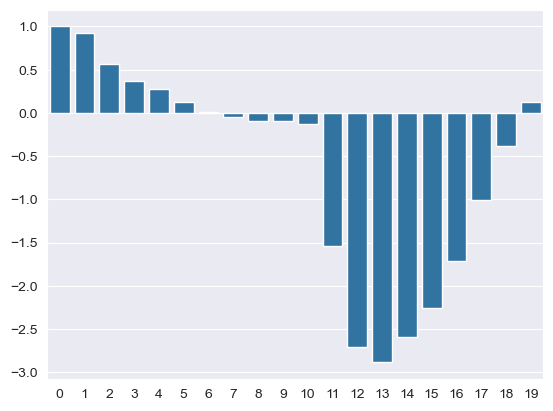

In [69]:
from statsmodels.tsa.arima_process import arma_impulse_response

ar = np.r_[1.0, -results.params.values[1:-1], results.params.values[-1]]
ir = arma_impulse_response(ar=ar, ma=[1.0], leads=20)
sns.barplot(ir);

This looks odd. Options:

- **Manual parameter estimation via OLS**
- manual implementation of impulse response

given the model:

INSERT

and the impulse response (IR):

$$\text{IR}(k=10) = \sum_{j=0}^{k-1} \text{IR}(j) \phi_{j+1} + \mathbb{I}_{k=0} \omega_1$$

UPDATE INDEX

In [ ]:
# manual impulse response


Going back to the ```statsmodels``` estimated parameters and model fitting summary: 

Interesting to see here, is the P-value significance from the OLS parameter estimation. Based on that, only the first two AR parameters and the exogenous parameter are statistically significant (on level $\alpha=0.05$).

Thus we could technically simplify the model a lot, by only taking the first two $\phi_1, \phi_2$ and $\omega_1$.

Hence the model would become an ARX(2) model:

$$P_t = -P_{t-1} \phi_1 - P_{t-2} \phi_2 + \omega_1 T_t$$

with $\phi_1 \approx 0.9246, \phi_2 \approx -0.2851, \omega_1 \approx 1.3917$.

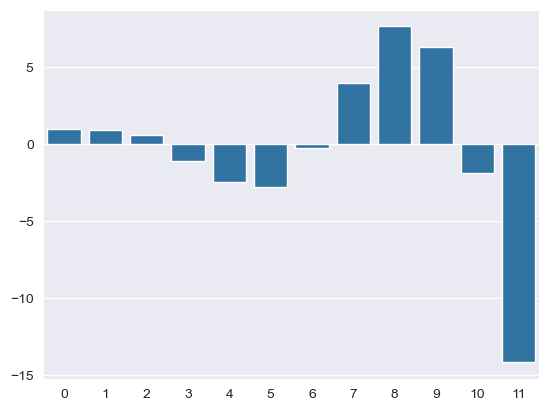

In [62]:
ir = arma_impulse_response(ar=[1, -0.9246, 0.2851, 1.3917], ma=[1], leads=12)
sns.barplot(ir);

One can see that it is somewhat similar up to lag $10$, then the scale becomes drastically different, because there are no higher-order terms/coefficients that scale down.

However, this is a known phenomenon. As soon as the lags exceed the number of coefficients, the amplitudes of the impulse respond become extreme.

**Manual Parameter Estimation**

Since it is an AR(10) model, we can use OLS to estimate parameters:

$$ P = 
[1, P_t, P_{t-1}, P_{t-2}, ..., P_{t-k}] =
\begin{bmatrix}
1 & p_1 & 0 & 0 & ... \\
1 & p_2 & p_1 & 0 & ... \\
1 & p_3 & p_2 & p_1 & ... \\
\vdots & \vdots & \vdots & \vdots \\
\end{bmatrix}$$

with $\mathbf{\phi} \in \mathbb{R}^k$
$$ => P_t = [1, - P_{t-1}, ... , - P_{t-k}] \cdot \mathbf{\phi} + [1, - T_{t-1}, ... , - T_{t-k}] \cdot \mathbf{\omega} + \mathbf{\varepsilon}_t$$